In [1]:
from IPython.display import clear_output
!pip install -qU --upgrade pip
!pip install -qU scikit-learn
!pip install -qU wandb

clear_output()

In [2]:
 !pip install -q /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl
# !pip install -qU /kaggle/input/whl-files/tensorflow-2.9.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q tensorflow-addons==0.18.0
!pip install -q tensorflow-probability==0.17.0

!pip install -q opencv-python-headless
!pip install -q seaborn
!pip install -q plotly

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.11.0 requires tensorflow<2.12,>=2.11.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.9.1 which is incompatible.


In [3]:
!pip install -qU pydot
!pip install -qU graphviz

In [4]:
#Basic python libraries
%config Completer.use_jedi = False
import os, re, math, random, shutil, warnings, gc
import glob
import numpy as np, pandas as pd
from IPython import display as ipd
from tqdm import tqdm

#Classical Ml tools
import sklearn
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

#OpenCV Library
import cv2

#Plotting tools 
from matplotlib.ticker import StrMethodFormatter
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

#Tensorflow and keras tools
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,BatchNormalization,Flatten,Input
from keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.applications import EfficientNetB3
from keras.callbacks import EarlyStopping

from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient

#Logging tools
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to avoid too many logging messages
pd.options.mode.chained_assignment = None
tf.get_logger().setLevel('ERROR')
py.init_notebook_mode(connected=True)

[percpu.cc : 560] RAW: rseq syscall failed with errno 1
[percpu.cc : 552] RAW: rseq syscall failed with errno 1


In [5]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('tf:',tf.__version__)

np: 1.24.1
pd: 1.5.3
sklearn: 1.2.2
tf: 2.9.1


In [6]:
devices = ['TPU', 'GPU']
img_size = [(1024,512), (512,256)]
# img_size = [(1024,512), (224,224)]
img_ext = ['png']

class Config:
    
    def __init__(self):
        
        self.competition   = 'rsna-bcd' 
        self._wandb_kernel = 'Gebreyowhans'
        
        self.debug = False
#         self.model_name = 'EfficientNetV1B3'
        
        self.device=devices[0]
        self.seed=150
        
        self.path='/kaggle/input/rsna-bcd-converted-dicom-images/'
        self.train_path= self.path+'train_images'
        self.train_path = self.path + 'train_images/'
        self.train_csv = self.path + 'train.csv'
        self.weights = "/kaggle/input/efficientnetb3-notop/efficientnetb3_notop.h5"
        
        self.output_path='/kaggle/working/'
        #number of folds for data-split
        self.folds = 5
        # which folds to train
        self.train_folds = [0, 1, 2]
        
        self.oversampling = True
        self.oversampling_factor = 10
        self.threshold = 0.6
        
        #Model Parameters
        self.batch_size=32
        self.epochs=10
        self.dropout=0.07
        self.optimizer='adam'
        self.loss='binary_crossentropy'
        self.patience=5
        self.img_size = img_size[1]
        self.img_ext = img_ext[0] 
        
        # ======Augumentation parameters====
        # pixel-augment
        self.sat  = [0.7, 1.3]
        self.cont = [1,2]
        self.bri  = 0.15
        self.hue  = 0.05

    

config=Config()

In [7]:
def seeding(seed):
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     os.environ['TF_DETERMINISTIC_OPS'] = str(seed)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    
    print("Seeding done")
    
seeding(config.seed)

Seeding done


In [8]:
if config.device == 'TPU':
    
    tpu = 'local' if config.device=='TPU' else None
    print('Connecting to TPU...')
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please try executing it again or turnon your TPU VM v3-8 in your accelrator section of this note book !')
    
    policy =tf.keras.mixed_precision.Policy('float32') 
    tf.keras.mixed_precision.set_global_policy(policy)
    
    tf.config.set_soft_device_placement(True)
    #strategy = tf.distribute.experimental.TPUStrategy(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    # TPU has to access the dataset from Google Cloud storage(GCS), so we have to set our path to GCS path
    config.path = KaggleDatasets().get_gcs_path(config.path.split('/')[3])
    config.train_path = config.path + '/' + 'train_images/'
    
    # get number of TPU cores connect at a runtime
    config.num_devices = strategy.num_replicas_in_sync
    
    # batch size of for the TPU
    config.batch_size = config.batch_size * config.num_devices
    print("Batch size for TPU :",config.batch_size)
    print(f'Running on {config.num_devices} TPU devices')


if config.device == 'GPU':
    
    #Number of GPU core connected
    num_devices = len(tf.config.list_physical_devices('GPU'))
    if num_devices > 1:
        config.num_devices = num_devices
        strategy = tf.distribute.MirroredStrategy()
        config.batch_size = config.batch_size * config.num_devices
        print(f'Running on {num_devices} GPU devices')
        print("Batch size for multi core GPU :",config.batch_size )
        
    elif num_devices == 1:
        strategy = tf.distribute.get_strategy()
        print(f'Running on {num_devices} GPU device')
        
    else:
        strategy = tf.distribute.get_strategy()
        config.device = 'CPU'
        print(f'Running on CPU')
    
    tf.config.optimizer.set_jit(True)
    
    if config.device == 'TPU':
        tf.keras.mixed_precision.set_global_policy("mixed_float16")
    else:
        tf.keras.mixed_precision.set_global_policy(policy="float32")

Connecting to TPU...
Batch size for TPU : 256
Running on 8 TPU devices


In [9]:
train_df = pd.read_csv(config.train_csv)

if config.debug:
    train_df = train_df.sample(30000).reset_index(drop=True)

In [10]:
train_df['image_path'] = config.train_path + train_df['patient_id'].astype(str) + '/' + train_df['image_id'].astype(str) + '.png'

In [11]:
tf.io.gfile.exists(train_df.image_path.iloc[0])

True

In [12]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,gs://kds-355e21a6f359c73ce37928004abba5305cc22...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,gs://kds-355e21a6f359c73ce37928004abba5305cc22...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,gs://kds-355e21a6f359c73ce37928004abba5305cc22...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,gs://kds-355e21a6f359c73ce37928004abba5305cc22...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,gs://kds-355e21a6f359c73ce37928004abba5305cc22...


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
 14  image_path            

# 9.Handle missing values 

In [14]:
def filter_missing_Features(df):
    total_missing_data = [df[col].isnull().sum() for col in df.columns]
    percentage_of_missing = [df[col].isnull().mean() for col in df.columns]
    result = pd.DataFrame(zip(total_missing_data, percentage_of_missing), columns=['total_missing_data', 'percentage_of_missing'], index=df.columns)
    result = result.sort_values('total_missing_data', ascending=False)
    return result

In [15]:
filter_missing_Features(train_df)

,total_missing_data,percentage_of_missing
BIRADS,28420,0.519504
density,25236,0.461302
age,37,0.000676
site_id,0,0.000000
patient_id,0,0.000000
image_id,0,0.000000
laterality,0,0.000000
view,0,0.000000
cancer,0,0.000000
biopsy,0,0.000000


* BIRADS Columun have almost half missing and we don't know how to fill it so we decided better to remove this feature
* The Age Columun also have very few missing values and we decided to fill these missing with average age value of the others

* Density Columun have also almost half of missing data and we decided to fill it with other category labeld 'E'

In [16]:
train_df = train_df.drop(['BIRADS'], axis=1)
train_df['age'] = train_df['age'].fillna(train_df['age'].mean())
train_df['density'] = train_df['density'].fillna('E')

In [17]:
filter_missing_Features(train_df)

,total_missing_data,percentage_of_missing
site_id,0,0.0
patient_id,0,0.0
image_id,0,0.0
laterality,0,0.0
view,0,0.0
age,0,0.0
cancer,0,0.0
biopsy,0,0.0
invasive,0,0.0
implant,0,0.0


# 10. Fix Data Types 

In [18]:
train_df['laterality'] = train_df['laterality'].astype('category')
train_df['view'] = train_df['view'].astype('category')
train_df['age'] = train_df['age'].astype('int64')
train_df['density'] = train_df['density'].astype('category')
train_df['image_path'] = train_df['image_path'].astype('string')
train_df['cancer'] = train_df['cancer'].astype('float32')

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   site_id                  54706 non-null  int64   
 1   patient_id               54706 non-null  int64   
 2   image_id                 54706 non-null  int64   
 3   laterality               54706 non-null  category
 4   view                     54706 non-null  category
 5   age                      54706 non-null  int64   
 6   cancer                   54706 non-null  float32 
 7   biopsy                   54706 non-null  int64   
 8   invasive                 54706 non-null  int64   
 9   implant                  54706 non-null  int64   
 10  density                  54706 non-null  category
 11  machine_id               54706 non-null  int64   
 12  difficult_negative_case  54706 non-null  bool    
 13  image_path               54706 non-null  string  
dtypes: boo

# 11. Numerical Categorization

In [20]:
train_df["age_bin"] = pd.cut(train_df['age'].values.reshape(-1), bins=5, labels=False)

# 12. Generate dummy variables 

In [21]:
cat_cols = ['laterality', 'view', 'density', 'difficult_negative_case']
train_df = pd.get_dummies(train_df, columns=cat_cols)

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   site_id                        54706 non-null  int64  
 1   patient_id                     54706 non-null  int64  
 2   image_id                       54706 non-null  int64  
 3   age                            54706 non-null  int64  
 4   cancer                         54706 non-null  float32
 5   biopsy                         54706 non-null  int64  
 6   invasive                       54706 non-null  int64  
 7   implant                        54706 non-null  int64  
 8   machine_id                     54706 non-null  int64  
 9   image_path                     54706 non-null  string 
 10  age_bin                        54706 non-null  int64  
 11  laterality_L                   54706 non-null  uint8  
 12  laterality_R                   54706 non-null 

In [23]:
train_df["laterality_L"] = train_df["laterality_L"].astype(int)
train_df["laterality_R"] = train_df["laterality_R"].astype(int)
train_df["view_CC"] = train_df["view_CC"].astype(int)
train_df["view_MLO"] = train_df["view_MLO"].astype(int)
train_df["density_A"] = train_df["density_A"].astype(int)
train_df["density_B"] = train_df["density_B"].astype(int)
train_df["density_C"] = train_df["density_C"].astype(int)
train_df["density_D"] = train_df["density_D"].astype(int)
train_df["density_E"] = train_df["density_E"].astype(int)
train_df["difficult_negative_case_False"] = train_df["difficult_negative_case_False"].astype(int)
train_df["difficult_negative_case_True"] = train_df["difficult_negative_case_True"].astype(int)

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   site_id                        54706 non-null  int64  
 1   patient_id                     54706 non-null  int64  
 2   image_id                       54706 non-null  int64  
 3   age                            54706 non-null  int64  
 4   cancer                         54706 non-null  float32
 5   biopsy                         54706 non-null  int64  
 6   invasive                       54706 non-null  int64  
 7   implant                        54706 non-null  int64  
 8   machine_id                     54706 non-null  int64  
 9   image_path                     54706 non-null  string 
 10  age_bin                        54706 non-null  int64  
 11  laterality_L                   54706 non-null  int64  
 12  laterality_R                   54706 non-null 

# 13. Stratified K-Fold Cross Validation 

* Stratified k-fold cross-validation is the same as just k-fold cross-validation, but Stratified k-fold  cross-validation, it does stratified sampling instead of random sampling. 

* This is particularly useful when dealing with imbalanced datasets, where one class or outcome variable is much more prevalent than the others.
* Without stratification, a standard K-Fold Cross Validation could lead to some folds containing little or no instances of the minority class, which would bias the evaluation of the model's performance.
* So since our dataset is highly imbalanced we decided to use this kind of cros validatio.

In [25]:
train_df.head(3)

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,implant,machine_id,image_path,...,view_LMO,view_ML,view_MLO,density_A,density_B,density_C,density_D,density_E,difficult_negative_case_False,difficult_negative_case_True
0,2,10006,462822612,61,0.0,0,0,0,29,gs://kds-355e21a6f359c73ce37928004abba5305cc22...,...,0,0,0,0,0,0,0,1,1,0
1,2,10006,1459541791,61,0.0,0,0,0,29,gs://kds-355e21a6f359c73ce37928004abba5305cc22...,...,0,0,1,0,0,0,0,1,1,0
2,2,10006,1864590858,61,0.0,0,0,0,29,gs://kds-355e21a6f359c73ce37928004abba5305cc22...,...,0,0,1,0,0,0,0,1,1,0


In [26]:
stratified_columns = train_df.columns[~train_df.columns.isin(['patient_id', 'image_id', 
                                                              'image_path', 'target', 
                                                              'site_id', 'width', 'height', 
                                                              'age', 'invasive', 
                                                              'implant', 'machine_id'])]

train_df['stratify'] = ''
for col in stratified_columns:
    train_df['stratify'] += train_df[col].astype(str)
     

train_df['stratify'] = train_df['stratify'].astype('string')

k_fold = StratifiedGroupKFold(n_splits=config.folds, shuffle=True, random_state=config.seed)


for fold, (train_idx, val_idx) in enumerate(k_fold.split(train_df, train_df['stratify'], train_df['patient_id'])):
    train_df.loc[val_idx, 'fold'] = fold

train_df['fold'] = train_df['fold'].astype('int32')

/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:909: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   site_id                        54706 non-null  int64  
 1   patient_id                     54706 non-null  int64  
 2   image_id                       54706 non-null  int64  
 3   age                            54706 non-null  int64  
 4   cancer                         54706 non-null  float32
 5   biopsy                         54706 non-null  int64  
 6   invasive                       54706 non-null  int64  
 7   implant                        54706 non-null  int64  
 8   machine_id                     54706 non-null  int64  
 9   image_path                     54706 non-null  string 
 10  age_bin                        54706 non-null  int64  
 11  laterality_L                   54706 non-null  int64  
 12  laterality_R                   54706 non-null 

In [28]:
print(train_df.groupby(['fold', "cancer"]).size())

fold  cancer
0     0.0       10694
      1.0         236
1     0.0       10631
      1.0         218
2     0.0       10738
      1.0         267
3     0.0       10685
      1.0         203
4     0.0       10800
      1.0         234
dtype: int64


In [29]:
train_df.head(3)

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,implant,machine_id,image_path,...,view_MLO,density_A,density_B,density_C,density_D,density_E,difficult_negative_case_False,difficult_negative_case_True,stratify,fold
0,2,10006,462822612,61,0.0,0,0,0,29,gs://kds-355e21a6f359c73ce37928004abba5305cc22...,...,0,0,0,0,0,1,1,0,0.002100100000000110,0
1,2,10006,1459541791,61,0.0,0,0,0,29,gs://kds-355e21a6f359c73ce37928004abba5305cc22...,...,1,0,0,0,0,1,1,0,0.002100000010000110,0
2,2,10006,1864590858,61,0.0,0,0,0,29,gs://kds-355e21a6f359c73ce37928004abba5305cc22...,...,1,0,0,0,0,1,1,0,0.002010000010000110,0


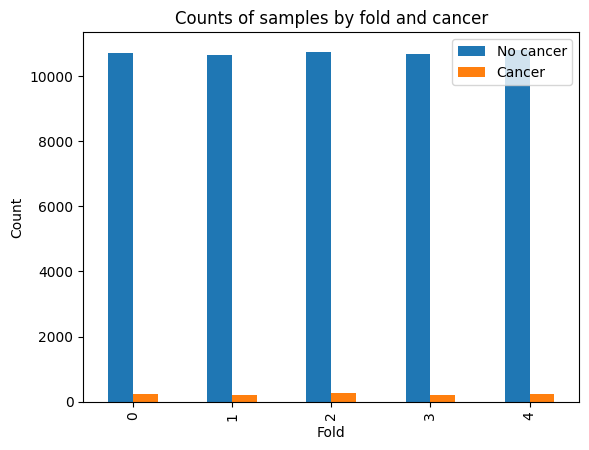

In [30]:
# reshape the data into a pivot table
counts = train_df.groupby(['fold', 'cancer']).size().unstack()

# plot the pivot table as a bar graph
counts.plot(kind='bar')
plt.xlabel('Fold')
plt.ylabel('Count')
plt.title('Counts of samples by fold and cancer')
plt.legend(['No cancer', 'Cancer'])
plt.show()


# 14. Build Dataset in the form of TF.Data.Dataset

**14.1 Decode images**
 * **tf.image.decode_png()** and **tf.image.decode_jpeg** are TensorFlow functions that decodes a PNG-encoded   image into a tensor of type uint8.
 
 * These functions takes the following arguments: 
     * **image**: A string tensor containing a PNG or jpeg -encoded image.
     * **channels**: An optional integer specifying the number of color channels in the decoded image. By  default, this is set to 3,
     

* The function returns a **uint8** tensor representing the decoded image with the shape of (height, width, channels) 
 


In [31]:
def decode_image(label=True, img_size=config.img_size, ext=config.img_ext):
    
    def _decode_image(Input_Image, label=None):
        image = tf.io.read_file(Input_Image['input_image'])
        
        if ext == 'png':
            ## PNG-encoded image into a tensor of type uint8.
            image = tf.image.decode_png(image, channels=3)
        elif ext in ['jpg', 'jpeg']:
            ## jpeg-encoded image into a tensor of type uint8.
            image = tf.image.decode_jpeg(image, channels=3)
        else:
            raise ValueError("Image extension not supported")
        
        ## explicit size needed for TPU
        image = tf.image.resize(image, img_size)
        ## convert image to floats in [0, 1] range
        image = tf.cast(image, tf.float32) / 255.0
        
        Input_Image['input_image'] = image
        
        if label is None:
            return Input_Image
        else:
            return Input_Image, label
    
    if label:
        return _decode_image
    else:
        return lambda x: _decode_image(x, None)

* 14.2 Data augumentation

In [32]:
def data_augment(label=True):
    def _augment(Input_Image, label=None):
        image = Input_Image['input_image']
        #position transforamtion
        image = tf.image.random_flip_left_right(image)
        # pixel-augment
        image = tf.image.random_hue(image, config.hue)
        image = tf.image.random_saturation(image,config.sat[0], config.sat[1])
        image = tf.image.random_contrast(image,config.cont[0], config.cont[1])
        image = tf.image.random_brightness(image,config.bri)
        Input_Image['input_image'] = image
        if label is not None:
            return Input_Image, label
        else:
            return Input_Image

    if label:
        return _augment
    else:
        return lambda x: _augment(x, None)


In [33]:
def build_dataset(df, input_features, image_size=config.img_size, batch_size=config.batch_size, 
                  label=True, shuffle=True, augment=False, repeat=False, cache=False, ext=config.img_ext):
    
    decode = decode_image(label, img_size=image_size, ext=ext)
    input_data = {'input_image': df['image_path'].values, 'input_features': df[input_features].values}
    
    if label:
        label_data = df['cancer'].apply(lambda x: int(x)).values
        dataset = tf.data.Dataset.from_tensor_slices((input_data, label_data))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(input_data)
        
    dataset = dataset.map(decode, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        dataset = dataset.map(data_augment(label), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(batch_size, reshuffle_each_iteration=True)
    if repeat:
        dataset = dataset.repeat()
    if cache:
        dataset = dataset.cache()
        
    dataset = dataset.batch(batch_size, drop_remainder=shuffle)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


# 15. Input Features

In [34]:
input_features = train_df.columns.difference(['patient_id', 'image_id', 'site_id', 'machine_id',
                                              'width', 'height', 'cancer', 'age', 
                                              'stratify', 'image_path', 'fold'])

In [35]:
Input_features_chagned_to_tensor  = build_dataset(train_df, input_features, batch_size=config.batch_size, label=True, 
                                     shuffle=False, augment=True, repeat=False, cache=False, ext=config.img_ext)

In [36]:
# for item in Input_features_chagned_to_tensor.take(1):
#     print(item)

# 16. Some augumented and non augumented images

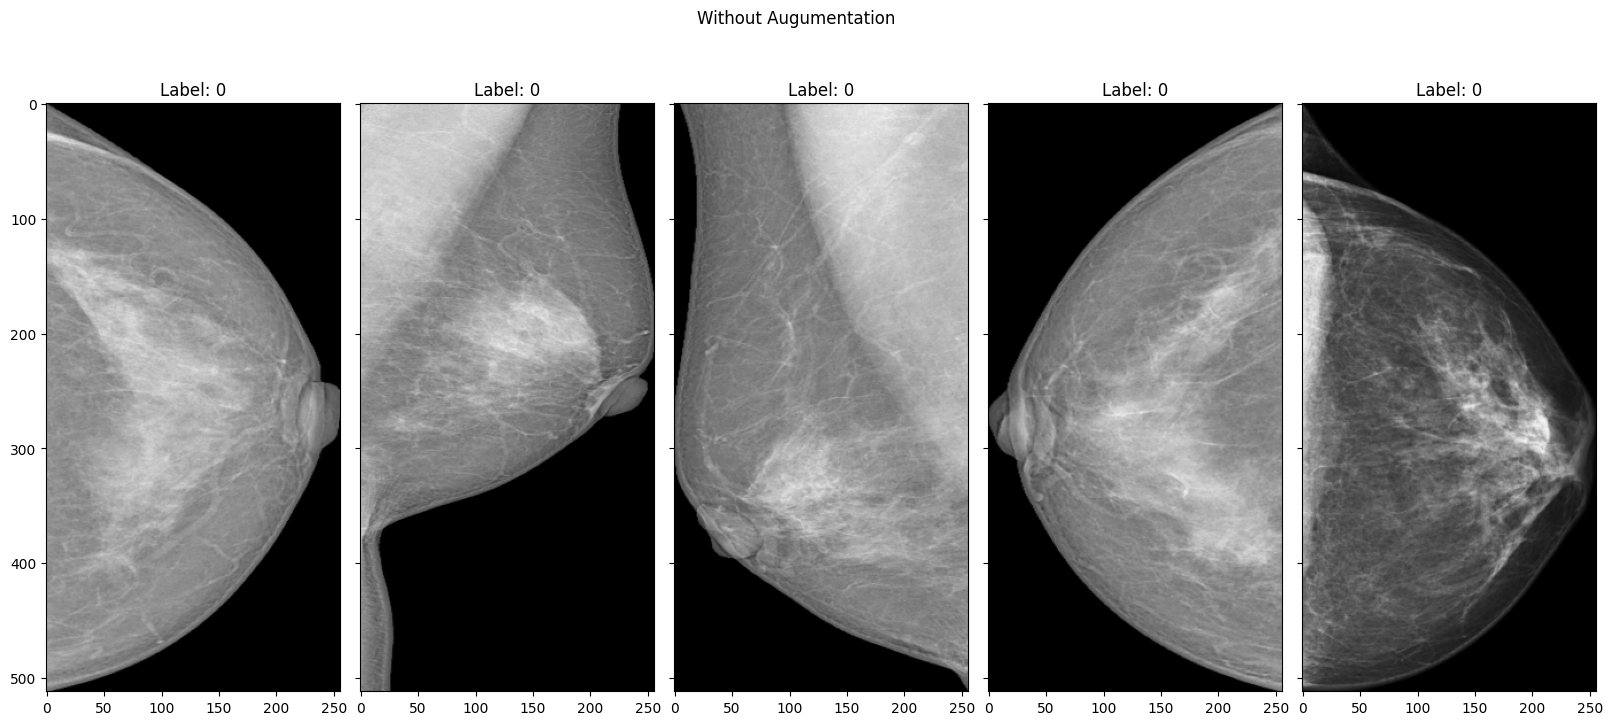

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


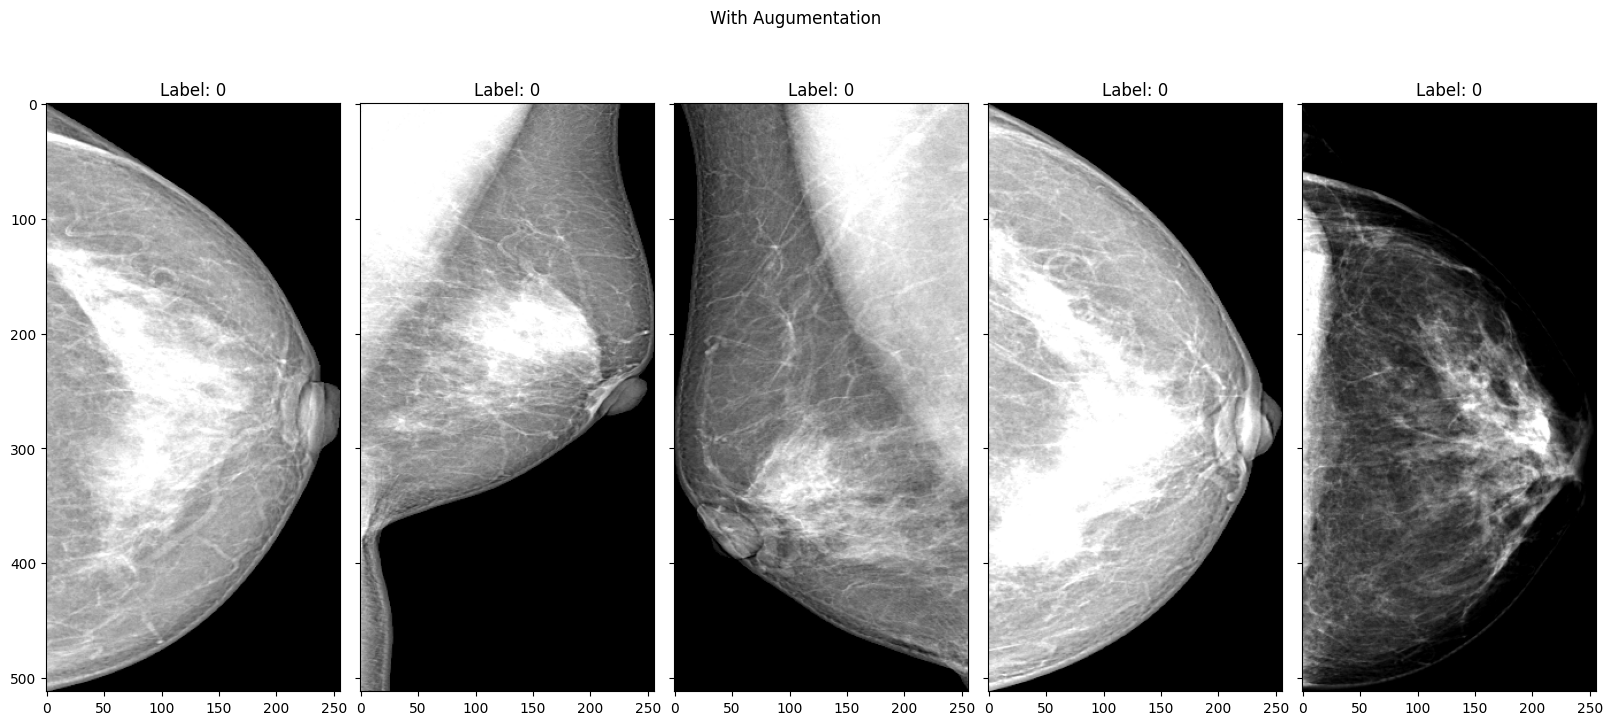

In [37]:
def show_images(dataset,  title="", rows=1, cols=5, figsize=(20, 8)):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.2)
    for i, (images, labels) in enumerate(dataset.take(1)):
        for j in range(rows*cols):
            grid[j].imshow(images['input_image'][j].numpy())
            grid[j].set_title(f"Label: {labels[j].numpy()}")
    plt.suptitle(title)
    plt.show()


sample_with_augument = build_dataset(train_df, input_features, batch_size=config.batch_size, label=True, 
                                     shuffle=False, augment=True, repeat=False, cache=False, ext=config.img_ext)

sample_without_augument = build_dataset(train_df, input_features, batch_size=config.batch_size, label=True, 
                                        shuffle=False, augment=False, repeat=False, cache=False, ext=config.img_ext)


show_images(sample_without_augument, title="Without Augumentation")
show_images(sample_with_augument, title="With Augumentation")

# 17. Normalization

In [38]:
train_df[input_features] = (train_df[input_features] - train_df[input_features].mean()) / train_df[input_features].std()
train_df[input_features] = train_df[input_features].astype('float32')

In [39]:
train_df[input_features]

,age_bin,biopsy,density_A,density_B,density_C,density_D,density_E,difficult_negative_case_False,difficult_negative_case_True,implant,invasive,laterality_L,laterality_R,view_AT,view_CC,view_LM,view_LMO,view_ML,view_MLO
0,-0.114632,-0.239552,-0.2453,-0.548466,-0.535029,-0.170135,1.080627,0.404882,-0.404882,-0.166576,-0.123205,1.003140,-1.003140,-0.018639,1.021724,-0.013521,-0.004275,-0.012094,-1.020304
1,-0.114632,-0.239552,-0.2453,-0.548466,-0.535029,-0.170135,1.080627,0.404882,-0.404882,-0.166576,-0.123205,1.003140,-1.003140,-0.018639,-0.978720,-0.013521,-0.004275,-0.012094,0.980082
2,-0.114632,-0.239552,-0.2453,-0.548466,-0.535029,-0.170135,1.080627,0.404882,-0.404882,-0.166576,-0.123205,-0.996852,0.996852,-0.018639,-0.978720,-0.013521,-0.004275,-0.012094,0.980082
3,-0.114632,-0.239552,-0.2453,-0.548466,-0.535029,-0.170135,1.080627,0.404882,-0.404882,-0.166576,-0.123205,-0.996852,0.996852,-0.018639,1.021724,-0.013521,-0.004275,-0.012094,-1.020304
4,-0.114632,-0.239552,-0.2453,-0.548466,-0.535029,-0.170135,1.080627,-2.469808,2.469808,-0.166576,-0.123205,1.003140,-1.003140,-0.018639,1.021724,-0.013521,-0.004275,-0.012094,-1.020304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,-1.297183,-0.239552,-0.2453,-0.548466,1.869022,-0.170135,-0.925372,0.404882,-0.404882,-0.166576,-0.123205,-0.996852,0.996852,-0.018639,-0.978720,-0.013521,-0.004275,-0.012094,0.980082
54702,-0.114632,-0.239552,-0.2453,-0.548466,1.869022,-0.170135,-0.925372,0.404882,-0.404882,-0.166576,-0.123205,1.003140,-1.003140,-0.018639,-0.978720,-0.013521,-0.004275,-0.012094,0.980082
54703,-0.114632,-0.239552,-0.2453,-0.548466,1.869022,-0.170135,-0.925372,0.404882,-0.404882,-0.166576,-0.123205,1.003140,-1.003140,-0.018639,1.021724,-0.013521,-0.004275,-0.012094,-1.020304
54704,-0.114632,-0.239552,-0.2453,-0.548466,1.869022,-0.170135,-0.925372,-2.469808,2.469808,-0.166576,-0.123205,-0.996852,0.996852,-0.018639,-0.978720,-0.013521,-0.004275,-0.012094,0.980082


# 18. Evaluation Metrics

In [40]:
def p_f1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred)
    tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    
    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())
    
    f1 = 2 * p * r / (p + r + tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return tf.reduce_mean(f1)

def p_f1_np(y_true, y_pred):
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    
    tp = np.sum(y_true * y_pred)
    tn = np.sum((1 - y_true) * (1 - y_pred))
    fp = np.sum((1 - y_true) * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    
    p = tp / (tp + fp + np.finfo(np.float32).eps)
    r = tp / (tp + fn + np.finfo(np.float32).eps)
    
    f1 = 2 * p * r / (p + r + np.finfo(np.float32).eps)
    f1 = np.where(np.isnan(f1), np.zeros_like(f1), f1)

    return np.mean(f1)

# 19.Model Building

In [41]:
def build_model(input_features, 
                loss=config.loss, 
                dropout=config.dropout, 
                optimizer=config.optimizer, 
                img_size=config.img_size):
    with strategy.scope():
#         input_image = tf.keras.layers.Input(shape=(*img_size,3), name='input_image')
        input_image = tf.keras.Input((*img_size, 3), name='input_image')
#         input_features = tf.keras.layers.Input(shape=[len(input_features)], name='input_features')
        
        efficientNetBase_model = tf.keras.applications.EfficientNetB3(input_shape=(*img_size,3),
                                                 include_top=False, 
                                                 drop_connect_rate=0.3,
                                                 weights='imagenet')(input_image)
        
        x = tf.keras.layers.MaxPooling2D()(efficientNetBase_model)
        x = tf.keras.layers.Flatten()(x)
        _output = tf.keras.layers.Dropout(dropout)(x)
        _output = tf.keras.layers.Dense(32, activation="relu")(_output)
        _output = tf.keras.layers.BatchNormalization()(_output)
#         _output = tf.keras.layers.Dropout(dropout)(_output)
#         _output = tf.keras.layers.Concatenate()([_output, input_features])
        _output = tf.keras.layers.Dense(1, activation='sigmoid')(_output)
                
#       
        model = tf.keras.Model(inputs=[input_image], outputs=_output)
#         model = tf.keras.Model(inputs=[input_image, input_features], outputs=_output)
        model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy', 
                       p_f1])

        return model


# 20. Model Summary

In [42]:
model = build_model(input_features,config.loss,config.dropout,config.optimizer,config.img_size)
model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 512, 256, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 16, 8, 1536)      10783535  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 4, 1536)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dropout (Dropout)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 32)                1572896

# 21. Ploting the model 

In [43]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# 22. Defining Model Compilation

In [44]:

##tf.keras.metrics.AUC(name='auc')

In [45]:
def lr_scheduler(batch_size=config.batch_size, plot=False):
    
    lr_start   = 0.000001
    lr_max     = 0.00000105 * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
    
    def lr_fn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    
    if plot:
        plt.figure(figsize=(10, 5))
        rng = [i for i in range(config.epochs+1)]
        y = [lr_fn(x) for x in rng]
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=rng, y=y, mode='lines+markers', name='lr'))
        fig.update_yaxes(tickformat=".5f")
        fig.update_layout(title='Learning Rate Schedule', xaxis_title='Epoch', yaxis_title='Learning Rate')
        fig.show()

    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_fn, verbose=False)
    return lr_callback


_ = lr_scheduler(batch_size=config.batch_size, plot=True)

<Figure size 1000x500 with 0 Axes>

# 23 Defining callback function saving models to output directory

In [46]:
# Create directory model weightes saving
save_model_dir = os.path.join(config.output_path,'models')
os.makedirs(os.path.dirname(save_model_dir), exist_ok=True)

In [47]:
def get_callbacks(batch_size, fold, patience=config.patience):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                             mode="min",
                                             patience=patience,
                                             restore_best_weights=True)
    
    best_model = tf.keras.callbacks.ModelCheckpoint(f'{save_model_dir}/model_{fold}.h5', 
                                                    monitor='val_p_f1',
                                                    mode='max', 
                                                    save_freq='epoch', 
                                                    save_best_only=True, 
                                                    save_weights_only=False,
                                                    verbose=1)
    callbacks_list = [early_stop, 
                      best_model,
                      lr_scheduler(batch_size)
                     ]
    return callbacks_list

# 24. Training 

In [48]:
results = {}

for fold in range(config.folds):
    
    if fold in config.train_folds:
        continue
    
    
    
    print(f'\n- Fold [{fold}] as validation set, and folds {[i for i in range(config.folds) if i != fold]} as training set\n')
    
    train = train_df.query("fold != @fold")
    validation = train_df.query("fold == @fold")
    
    print("number of examples in training : ",len(train))
    print("number of examples in validation : ",len(validation))

    if config.oversampling:
        
        numberofCancers=train.query('cancer == 1')
        numberofNonCancer=train.query('cancer == 0')
        
        print("numberofCancers :",len(numberofCancers))
        print("numberofNonCancer :",len(numberofNonCancer))
        
        positive = train.query('cancer == 1').sample(frac=config.oversampling_factor, replace=True, 
                                                     random_state=config.seed)
        negative = train.query('cancer == 0')
        train = pd.concat([positive, negative], axis=0).reset_index(drop=True)
        print("number of examples in after upsampling : ",len(train))
    
    train_dataset = build_dataset(train, input_features, batch_size=config.batch_size, 
                                  shuffle=True, augment=True, repeat=False, cache=True)
          
    val_dataset = build_dataset(validation, input_features, batch_size=config.batch_size, 
                                shuffle=False, augment=False, repeat=False, cache=True)
    
    class_weight = compute_class_weight(class_weight='balanced',
                                        classes=train["cancer"].unique(),
                                        y=train["cancer"].values)
    
    model = build_model(input_features)
    
    history = model.fit(train_dataset, 
                        validation_data = val_dataset, 
                        epochs = config.epochs,
                        callbacks = get_callbacks(config.batch_size, fold),
                        class_weight = dict(zip(train["cancer"].unique(), class_weight)),
                        steps_per_epoch = len(train) // config.batch_size)
    
    print('========================out-of-fold predictions ============================================')
    print('======== Loading saved model ========================')
    model.load_weights(f'{save_model_dir}/model_{fold}.h5')

    print('================Predicting OOF validation set ========================')
    b_val_dataset = build_dataset(validation, input_features,
                                  batch_size=config.batch_size, 
                                  shuffle=False, augment=True, repeat=False, cache=True)
    
    #Remove singleton dimensionality with squeeze function
    validation['pred'] = np.squeeze(model.predict(b_val_dataset, verbose=1).astype('float32'))
    validation['pred'] = (validation['pred'] > config.threshold).astype(int)



    print(' ================Compute metrics========================')
    pf = p_f1_np(validation['cancer'], validation['pred'])
    auc = roc_auc_score(validation['cancer'], validation['pred'])
    accuracy = accuracy_score(validation['cancer'], validation['pred'])

    
    results[fold] = {'p_f1': pf,'accuracy': accuracy}
    print(f'- P-F1: {pf}, Accuracy: {accuracy}\n')
   
    
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    


- Fold [3] as validation set, and folds [0, 1, 2, 4] as training set

number of examples in training :  43818
number of examples in validation :  10888
numberofCancers : 955
numberofNonCancer : 42863
number of examples in after upsampling :  52413
Epoch 1/10


/usr/local/lib/python3.8/site-packages/keras/engine/functional.py:566: UserWarning:

Input dict contained keys ['input_features'] which did not match any model input. They will be ignored by the model.

2023-05-02 11:56:04.314002: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2023-05-02 11:56:07.210531: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


204/204 [==============================] - ETA: 0s - loss: 0.8770 - accuracy: 0.4967 - p_f1: 0.1243 

2023-05-02 13:22:25.704400: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-02 13:22:26.364608: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



Epoch 1: val_p_f1 improved from -inf to 0.03119, saving model to /kaggle/working/models/model_3.h5
204/204 [==============================] - 6410s 31s/step - loss: 0.8770 - accuracy: 0.4967 - p_f1: 0.1243 - val_loss: 0.6393 - val_accuracy: 0.6458 - val_p_f1: 0.0312 - lr: 1.0000e-06
Epoch 2/10
204/204 [==============================] - ETA: 0s - loss: 0.7519 - accuracy: 0.4860 - p_f1: 0.1245
Epoch 2: val_p_f1 improved from 0.03119 to 0.03178, saving model to /kaggle/working/models/model_3.h5
204/204 [==============================] - 85s 414ms/step - loss: 0.7519 - accuracy: 0.4860 - p_f1: 0.1245 - val_loss: 0.7086 - val_accuracy: 0.4862 - val_p_f1: 0.0318 - lr: 5.4560e-05
Epoch 3/10
204/204 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.4647 - p_f1: 0.1248
Epoch 3: val_p_f1 did not improve from 0.03178
204/204 [==============================] - 81s 397ms/step - loss: 0.7048 - accuracy: 0.4647 - p_f1: 0.1248 - val_loss: 0.6738 - val_accuracy: 0.6056 - val_p_f1

2023-05-02 13:49:28.153658: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-02 13:49:28.756904: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


43/43 [==============================] - 911s 20s/step
 ================Compute metrics========================
- P-F1: 0.0, Accuracy: 0.9805290227773695


- Fold [4] as validation set, and folds [0, 1, 2, 3] as training set

number of examples in training :  43672
number of examples in validation :  11034
numberofCancers : 924
numberofNonCancer : 42748
number of examples in after upsampling :  51988
Epoch 1/10


/usr/local/lib/python3.8/site-packages/keras/engine/functional.py:566: UserWarning:

Input dict contained keys ['input_features'] which did not match any model input. They will be ignored by the model.

2023-05-02 14:05:48.740182: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2023-05-02 14:05:51.285288: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


203/203 [==============================] - ETA: 0s - loss: 0.8871 - accuracy: 0.5061 - p_f1: 0.1204 

2023-05-02 15:18:10.334578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-02 15:18:10.906195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



Epoch 1: val_p_f1 improved from -inf to 0.03320, saving model to /kaggle/working/models/model_4.h5
203/203 [==============================] - 5325s 26s/step - loss: 0.8871 - accuracy: 0.5061 - p_f1: 0.1204 - val_loss: 0.7195 - val_accuracy: 0.5605 - val_p_f1: 0.0332 - lr: 1.0000e-06
Epoch 2/10
203/203 [==============================] - ETA: 0s - loss: 0.7525 - accuracy: 0.4938 - p_f1: 0.1208
Epoch 2: val_p_f1 improved from 0.03320 to 0.03530, saving model to /kaggle/working/models/model_4.h5
203/203 [==============================] - 85s 420ms/step - loss: 0.7525 - accuracy: 0.4938 - p_f1: 0.1208 - val_loss: 0.7233 - val_accuracy: 0.4405 - val_p_f1: 0.0353 - lr: 5.4560e-05
Epoch 3/10
203/203 [==============================] - ETA: 0s - loss: 0.7030 - accuracy: 0.4677 - p_f1: 0.1214
Epoch 3: val_p_f1 did not improve from 0.03530
203/203 [==============================] - 84s 411ms/step - loss: 0.7030 - accuracy: 0.4677 - p_f1: 0.1214 - val_loss: 0.6597 - val_accuracy: 0.6843 - val_p_f1

2023-05-02 15:46:36.669203: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-02 15:46:37.277728: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


44/44 [==============================] - 840s 18s/step
 ================Compute metrics========================
- P-F1: 0.03519058192106276, Accuracy: 0.8807322820373391



# 25. Plot of accuracy and loss functions

In [49]:
def plot_evaluation_metrics(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "r", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "g", label="Validation accuracy")
    
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training loss")
    plt.plot(epochs, val_loss, "g", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()


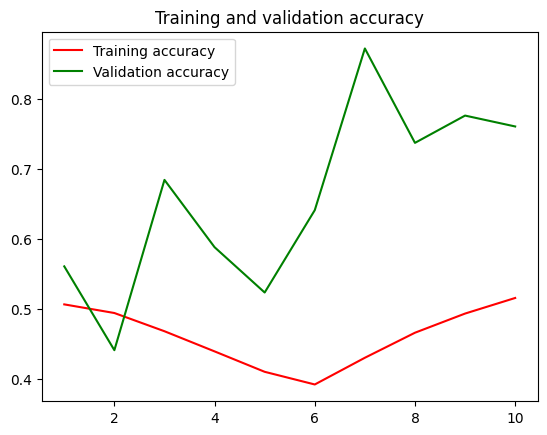

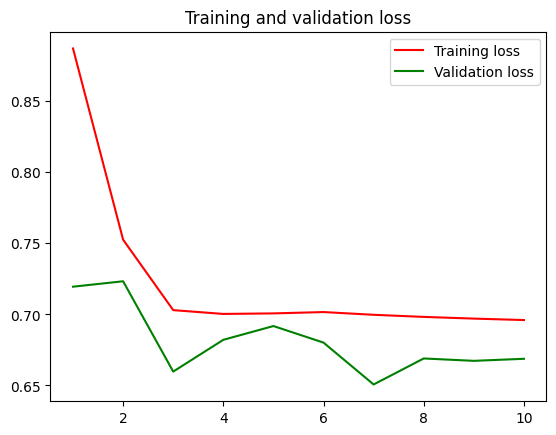

In [50]:
plot_evaluation_metrics(history)

In [51]:
tf.keras.backend.clear_session()
# experiment.end()